# Calculate and save footprints over entire period.

* Intersect with a landscape classification map 


In [6]:
%matplotlib notebook
import numpy as np
import pandas as pd
import rasterio
from rasterio import features
from rasterio.transform import from_origin
from rasterio.plot import show

import matplotlib.pyplot as plt
import datetime
import Footprint_Processing as FP
import geopandas as gpd
import os


try:
    os.mkdir('temp/')
except:
    pass

D_path = 'Data/'
RasterPath = D_path+'Footprints/'
DataName = 'FI_Data_2017_PostProcessing.csv'
Data = pd.read_csv(D_path+DataName,parse_dates=['datetime'],index_col=['datetime'])
Data.head()

,Tau,qc_Tau,rand_err_Tau,H,qc_H,rand_err_H,LE,qc_LE,rand_err_LE,co2_flux,...,ch4_flux_Pru*,Dir,Zm,fco2,fch4,DOY,ER,Sun_Angle,Daytime,Z0
datetime,,,,,,,,,,,,,,,,,,,,,
2017-06-23 00:00:00-06:00,0.073630,0.0,NaN,6.368283,1.0,NaN,12.286230,0.0,NaN,-0.101038,...,0.023772,15.0,2.87,-0.101038,0.023772,174,-0.101038,8.449197,1,0.011457
2017-06-23 00:30:00-06:00,0.074988,0.0,NaN,-17.662798,0.0,NaN,2.259226,1.0,NaN,0.561228,...,0.022941,345.0,2.87,0.561228,0.022941,174,0.561228,8.449197,1,0.008766
2017-06-23 01:00:00-06:00,0.108962,0.0,NaN,-11.517344,0.0,NaN,1.372132,1.0,NaN,0.673105,...,0.025634,345.0,2.87,0.673105,0.025634,174,0.673105,5.502266,1,0.008251
2017-06-23 01:30:00-06:00,0.084511,0.0,NaN,-9.591518,0.0,NaN,NaN,2.0,NaN,0.506380,...,0.025041,345.0,2.87,0.506380,0.025041,174,0.506380,5.502266,1,0.006339
2017-06-23 02:00:00-06:00,0.070018,0.0,NaN,-8.110602,0.0,NaN,1.213447,1.0,NaN,0.490812,...,0.024376,15.0,2.87,0.490812,0.024376,174,0.490812,3.668524,1,0.006465


# Date Range & Paramters

* Read & filter the data

In [7]:
DateRange=['2017-6-12 12:00:00','2017-9-14 23:30:00']
# DateRange=['2017-7-24 12:00:00','2017-7-24 20:30:00']  ## Subset for testing
Axis = 35
rs = [.1,.25,.5,.75,.8,.9,.95,.98]

Width = 2000#
dx = 2#
nx = int(Width/dx)

XY = [504679.13,7695885.39]
 
fp_params={'dx':dx,'nx':nx,'rs':rs}
thresh=.05

Run_Name=str(Width)+'mx'+str(dx)+'m'
    
Data['Run']=0
Data['Zm'] = 2.87
Data['Z_L'] = Data['Zm']/Data['L']

diff = []
Data['canopy_height'] = (Data['Canopy_Height_2']*.67+Data['Canopy_Height_1']*(.33))*.01
Data['canopy_height'] = Data['canopy_height'].bfill()
Data['Zo'] = Data['canopy_height']*.15
Data['d']=Data['canopy_height']*.66
Data['Zm']=Data['Zm']-Data['d']
Data['Z_L'] = Data['Zm']/Data['L']
Data['Z0'] = Data['Zm']*np.exp(-.41*Data['wind_speed']/Data['u*'])
Data.loc[(Data['Z_L']<-thresh)|(Data['Z_L']>thresh),['Z0']]=np.nan
Data.loc[(Data['wind_speed']<1.5),['Z0']]=np.nan
diff.append(Data['Z0'].values.copy())
Daily = Data.resample('D').median()
Data['Ratio'] = Data['u*']/Data['wind_speed']
Wind_Groups_median = Data.groupby(['Dir']).median()
Wind_Groups_std = Data.groupby(['Dir']).std()
Wind_Groups_Ct = Data.groupby(['Dir']).count()
Wind_Groups_CI = Wind_Groups_std/Wind_Groups_Ct**.5*1.96

Wind_Groups_median['Dir'] = Wind_Groups_median.index*np.pi/180

Data.loc[(np.isfinite(Data['Zo'])==True)&(np.isfinite(Data['co2_flux'])==True)&
         (Data['u*']>.1)&
         (Data.index>DateRange[0])&
         (Data.index<DateRange[1])&              # Run a subset for teting
     ((Data['wind_dir']<Axis+180-30)|(Data['wind_dir']>Axis+180+30)),
     ['Run']]=1

try:
    Data = Data.drop(['datetime'],axis=1)
except:pass
Run = Data.loc[Data['Run']==1].reset_index()
Runs = Run.shape[0]
west = XY[0]-(nx*dx)/2
north = XY[1]+(nx*dx)/2
Transform = from_origin(west,north,dx,dx)
print(Transform)
print(west,north)
Data.shape

| 2.00, 0.00, 503679.13|
| 0.00,-2.00, 7696885.39|
| 0.00, 0.00, 1.00|
503679.13 7696885.39


(3962, 311)

## Footprints

[504679.13, 7695885.39]
{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 1001, 'height': 1001, 'count': 1, 'crs': CRS.from_epsg(32608), 'transform': Affine(2.0, 0.0, 503679.13,
       0.0, -2.0, 7696885.39), 'tiled': False, 'interleave': 'band'}
Class    CollapsePolygonRim
Pct                   100.0
dtype: object


<IPython.core.display.Javascript object>


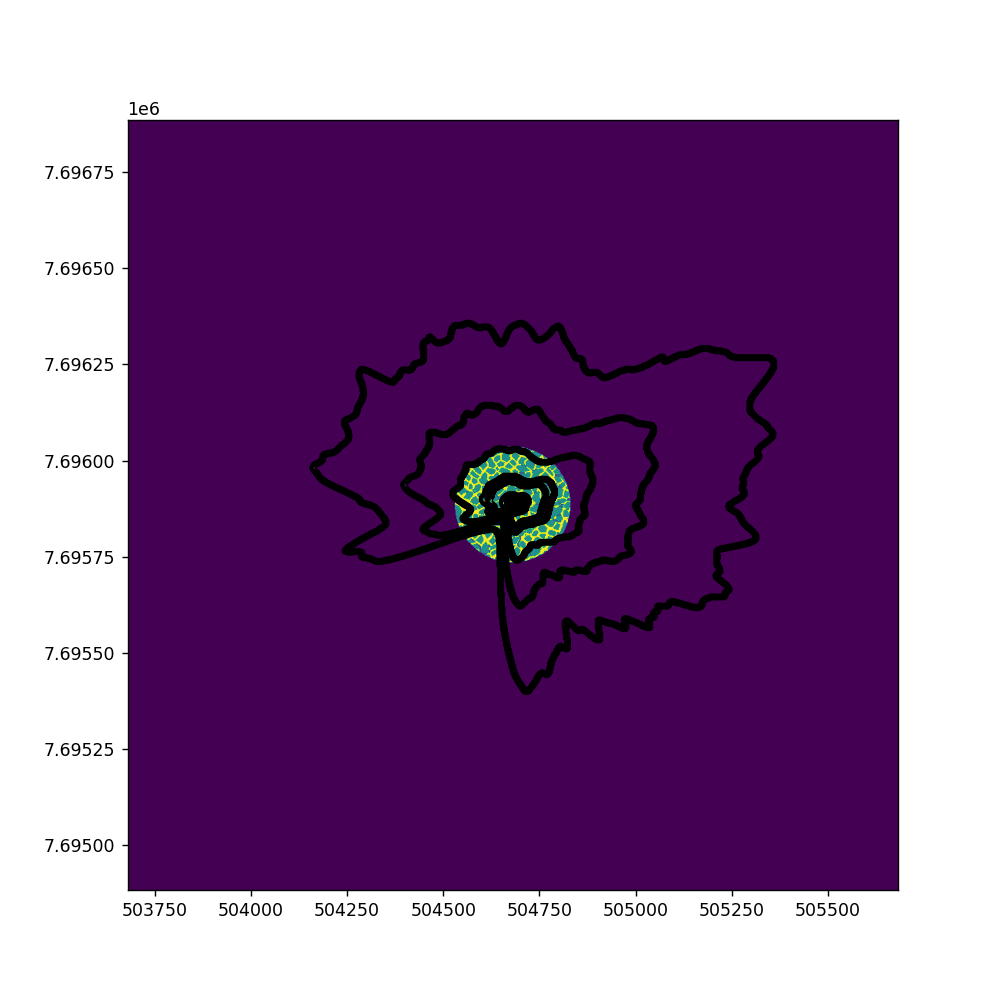

| 2.00, 0.00, 503679.13|
| 0.00,-2.00, 7696885.39|
| 0.00, 0.00, 1.00|
{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 1001, 'height': 1001, 'count': 1, 'crs': CRS.from_epsg(32608), 'transform': Affine(2.0, 0.0, 503679.13,
       0.0, -2.0, 7696885.39), 'tiled': False, 'interleave': 'band'}
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||] 100.0%
{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 1001, 'height': 1001, 'count': 1, 'crs': CRS.from_epsg(32608), 'transform': Affine(2.0, 0.0, 503679.13,
       0.0, -2.0, 7696885.39), 'tiled': False, 'interleave': 'band'}
2.0


C:\Users\User\.conda\envs\geo-env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   contour                                           geometry           area
0     0.10  POLYGON ((504685.130 7695891.390, 504685.139 7...     149.031568
1     0.25  POLYGON ((504669.130 7695885.390, 504668.934 7...     580.714203
2     0.50  POLYGON ((504654.431 7695888.909, 504654.332 7...    2284.539633
3     0.75  POLYGON ((504620.099 7695893.141, 504619.997 7...   11317.980116
4     0.80  POLYGON ((504602.099 7695897.141, 504601.997 7...   17817.839338
5     0.90  POLYGON ((504526.102 7695907.136, 504525.931 7...   65279.332062
6     0.95  POLYGON ((504398.099 7695935.141, 504397.997 7...  202164.412405
7     0.98  POLYGON ((504162.099 7695979.141, 504161.997 7...  653169.513609


In [8]:
with rasterio.open('LC_Class'+str(dx)+'m.tif','w+',driver='GTiff',width = nx+1, height = nx+1,
                   count = 1,dtype=np.float64,transform = Transform,crs = ({'init': 'EPSG:32608'})) as out:
    out_arr = out.read(1)
    params = out.profile
    print(XY)
    print(params)
    bounds = (out.bounds)
from shapely.geometry import box
geom = box(*bounds)
df = gpd.GeoDataFrame({"id":1,"geometry":[geom]})
df.to_file(D_path+'boundary.shp')

gdf = gpd.read_file(D_path+'/FI_FP_Landscape_Class.shp')
gdf['Class']=gdf['FIRST_Clas']
gdf['Pct'] = gdf['Shape_Area']/gdf['Shape_Area'].sum()*100
print(gdf[['Class','Pct']].sum())

fig,ax=plt.subplots(1,1,figsize = (8,8))
print(params['transform'])

LC = gdf
shapes = ((geom,value) for geom,value in zip(LC['geometry'],LC['Id']))
with rasterio.open('temp/LC_Class'+str(dx)+'m.tif','w+',**params) as out:
    out_arr = out.read(1)
    params = out.profile
    print(params)
    Image = features.rasterize(shapes=shapes,fill = 100,out = out_arr,transform = Transform,default_value=0)
    print(Image)
    out.write(Image,1)

with rasterio.open('temp/LC_Class'+str(dx)+'m.tif','r') as Im:
    show(Im.read([1]),transform=Im.profile['transform'],ax=ax)
    Vals = Im.read(1)

Go = True
if Go == True:
    Domain = 'temp/LC_Class'+str(dx)+'m.tif'
    FP_Data = FP.Calculate(RasterPath,Run,Domain,XY,params,Classes=LC,ax=ax,
                           nx=nx,dx=dx,rs=rs,OtherClass='FarField',Name=Run_Name)
        
    Data = Data.merge(FP_Data.Intersections,left_on='datetime', right_on='datetime', how='outer')



In [9]:
# File_Name = 'FI_Footprints_'+str(datetime.datetime.now()).split(' ')[0]+'_'+str(Width)+'m'+'x'+str(dx)+'m.csv'
# Data.to_csv(Output_Path+File_Name)
print(Data.columns)

Index(['datetime', 'Tau', 'qc_Tau', 'rand_err_Tau', 'H', 'qc_H', 'rand_err_H',
       'LE', 'qc_LE', 'rand_err_LE',
       ...
       'Z0', 'Run', 'Z_L', 'canopy_height', 'd', 'Ratio', 'Collapse',
       'Polygon', 'Rim', 'FarField'],
      dtype='object', length=316)


In [11]:
Data.to_csv(D_path+'FI_Data_2017_w_Footprint.csv')